# Fast learning of fast transforms, with guarantees

A Jupyter notebook to execute experiment scripts of the repository, and plot the results to reproduce the figures of the paper "Fast learning of fast transforms, with guarantees" (Quoc-Tung Le, Léon Zheng, Elisa Riccietti, Rémi Gribonval).

## FAµST library

The hierarchical factorization method when fixing the butterfly supports has been implemented in the FAµST library, version 3.25: https://faust.inria.fr/

In [1]:
!pip install pyfaust --upgrade

     |████████████████████████████████| 3.1 MB 3.7 MB/s eta 0:00:01
  Attempting uninstall: pyfaust
    Found existing installation: pyfaust 3.24.1
    Uninstalling pyfaust-3.24.1:
      Successfully uninstalled pyfaust-3.24.1


In [2]:
import pyfaust
print(pyfaust.__version__)

3.25.0


As a toy example we factorize 

In [11]:
from pyfaust import Faust, wht, dft
from pyfaust.fact import butterfly
H = wht(32).toarray() # it works with dft too!
F = butterfly(H)
(F-H).norm()/Faust(H).norm()

factorization #1


1.3286486844164017e-15

factorization #2
factorization #3
factorization #4


## Getting started

Make sure that the source file have been installed via the command:

In [9]:
!pip install -e .

Obtaining file:///Users/tung/Doctorant2/Report/Codegithub/butterfly
  Attempting uninstall: src
    Found existing installation: src 0.0.0
    Uninstalling src-0.0.0:
      Successfully uninstalled src-0.0.0
  Running setup.py develop for src


As a toy example we run a hierarchical factorization on the Hadamard matrix.

In [10]:
!rm results/hadamard_J=4_balanced.pkl
!mkdir results

%run scripts/hierarchical_factorization \
    --num_factors 4 \
    --matrix hadamard \
    --tree balanced \
    --results_path results/hadamard_J=4_balanced.pkl

rm: results/hadamard_J=4_balanced.pkl: No such file or directory
========= hadamard matrix with noise_m = 0.0, noise_std = 0.0, BP projection with 4 factors, where perm = identity, tree = balanced, max_depth = -1
Generating Hadamard matrix to factorize...
BP projection, with fixed P = identity, and balanced tree, max_depth=-1
Loss: 2.782487803465936e-16
Factorization time: 0.005640983581542969


We extract the results via pandas.

In [12]:
import pandas as pd
pd.read_pickle("results/hadamard_J=4_balanced.pkl")

,num_factors,noise_m,noise_std,matrix,tree,max_depth,perm,loss,time
0,4,0.0,0.0,hadamard,balanced,-1,identity,2.782488e-16,0.005641


## Experiment 1: comparing balanced vs. unbalanced hierarchical factorization
We show how to reproduce Figure 4 in the paper.

In [13]:
import matplotlib.pyplot as plt
import matplotlib

In [14]:
# Set list_num_factors = range(2, 14) to test all sizes
list_num_factors = range(2, 10)

!rm results/hierarchical_vs_comb.pkl
!mkdir results

for num_factors in list_num_factors:
    %run scripts/hierarchical_comb_vs_balanced \
        --num_factors $num_factors \
        --noise_m 0.0 \
        --main_std 1.0 \
        --matrix random \
        --noise_std 0.1 \
        --perm identity \
        --repeat 1 \
        --results_path results/hierarchical_vs_comb.pkl

rm: results/hierarchical_vs_comb.pkl: No such file or directory
mkdir: results: File exists
========= random matrix with noise_m = 0.0, noise_std = 0.1, BP projection with 2 factors, where perm = identity, max_depth = -1
Generating random matrix to factorize...

EXP_ID: 1/1
Adding noise with mean 0.0 and std 0.1
Noise over signal: 30.238394621420937 %
--------------------------------------------------
BP projection, with fixed P = identity, and comb tree, max_depth=-1
Loss absolute: 0.08011682291957618 (6.6089196599703595 %)
Factorization time: 0.0012662410736083984
--------------------------------------------------
BP projection, with fixed P = identity, and balanced tree, max_depth=-1
Loss absolute: 0.08011682291957618 (6.6089196599703595 %)
Factorization time: 0.0017061233520507812
--------------------------------------------------

RESULTS DATAFRAME
  num_factors  noise_m  noise_std  matrix main_m  main_std      tree  \
0           2      0.0        0.1  random      0       1.0    

Loss absolute: 19.80543698426992 (10.47836643645561 %)
Factorization time: 0.056000709533691406
--------------------------------------------------
BP projection, with fixed P = identity, and balanced tree, max_depth=-1
Loss absolute: 13.016095856505265 (6.886362672271091 %)
Factorization time: 0.049009084701538086
--------------------------------------------------

RESULTS DATAFRAME
   num_factors  noise_m  noise_std  matrix main_m  main_std      tree  \
0            2      0.0        0.1  random      0       1.0      comb   
1            2      0.0        0.1  random      0       1.0  balanced   
2            3      0.0        0.1  random      0       1.0      comb   
3            3      0.0        0.1  random      0       1.0  balanced   
4            4      0.0        0.1  random      0       1.0      comb   
5            4      0.0        0.1  random      0       1.0  balanced   
6            5      0.0        0.1  random      0       1.0      comb   
7            5      0.0       

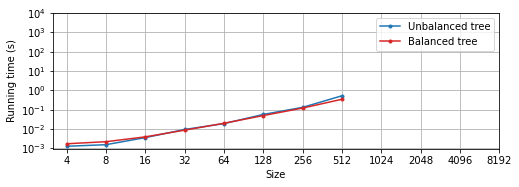

In [15]:
stats = pd.read_pickle("results/hierarchical_vs_comb.pkl")
stats_comb = stats[stats["tree"] == "comb"]
stats_balanced = stats[stats["tree"] == "balanced"]

fig1, ax1 = plt.subplots(figsize=(8, 2.5))
plt.grid()
ax1.plot(2 ** stats_comb["num_factors"], stats_comb["time"], marker='.', color='tab:blue', label='Unbalanced tree')
ax1.plot(2 ** stats_balanced["num_factors"], stats_balanced["time"], marker='.', color='tab:red', label='Balanced tree')
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Size")
ax1.set_ylabel("Running time (s)")
ax1.set_xticks(2 ** np.array(range(2, 14)))
ax1.set_yticks([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.legend()
plt.minorticks_off()

## Experiment 2: comparing hierarchical factorization vs. iterative gradient-based method

We show how to reproduce Figure 3 in the paper.

In [16]:
# Set listJ = [3, 6, 9] to reproduce the whole figure
# Set trial to 10 to reproduce several time the experiment
listJ = [3, 6]

for num_factors in listJ:
    %run scripts/iterative_vs_hierarchical_dft \
        --k $num_factors \
        --sigma 0.01 \
        --trial 2 \
        --results_path results/iterative_vs_hier_{num_factors}.npz


EXP_ID: 1/2
Iterative gradient descent method: loss=0.5239239564276852, time=0.15485715866088867
Balanced hierarchical factorization: loss=0.5239966352164368, time=0.011753082275390625
Unbalanced hierarchical factorization: loss=0.523997155120812, time=0.011549234390258789

EXP_ID: 2/2
Iterative gradient descent method: loss=5.5150317197634, time=0.22368311882019043
Balanced hierarchical factorization: loss=0.5433019598003207, time=0.013075828552246094
Unbalanced hierarchical factorization: loss=0.5432673138247766, time=0.010387897491455078

FINAL RESULTS
Noise level:
[0.7144724341314593, 0.7770879911155733]
Loss for gradient iterative method:
[0.5239239564276852, 5.5150317197634]
Time for gradient iterative method:
[0.15485715866088867, 0.22368311882019043]
Loss for hierarchical balanced method:
[0.5239966352164368, 0.5433019598003207]
Time for hierarchical balanced method:
[0.011753082275390625, 0.013075828552246094]
Loss for hierarchical unbalanced method:
[0.523997155120812, 0.543

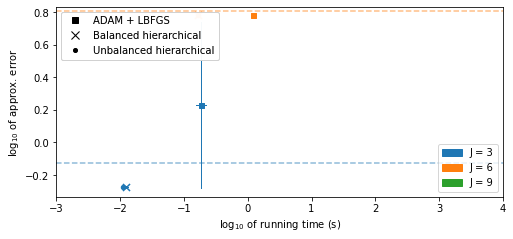

In [17]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

A1 = []
T1 = []
A2 = []
T2 = []
A3 = []
T3 = []
N = []

for k in listJ:
    a = np.load(f"results/iterative_vs_hier_{k}.npz")
    A1.append(a["acc_iter"])
    A2.append(a["acc_balanced"])
    A3.append(a["acc_unbalanced"])
    T1.append(a["time_iter"])
    T2.append(a["time_balanced"])
    T3.append(a["time_unbalanced"])
    N.append(a["noise"])


A1 = np.log10(np.array(A1)) #in the training code, A1 = 0.5 * \|\|_F^2
A2 = np.log10(np.array(A2))
A3 = np.log10(np.array(A3))
T1 = np.log10(np.array(T1))
T2 = np.log10(np.array(T2))
T3 = np.log10(np.array(T3))

A1_mean = np.mean(A1, axis = 1)
A1_max = np.max(A1, axis = 1)
A1_min = np.min(A1, axis = 1)
A1_std = np.std(A1, axis = 1)

A2_mean = np.mean(A2, axis = 1)
A2_max = np.max(A2, axis = 1)
A2_min = np.min(A2, axis = 1)
A2_std = np.std(A2, axis = 1)

T1_mean = np.mean(T1, axis = 1)
T1_max = np.max(T1, axis = 1)
T1_min = np.min(T1, axis = 1)
T1_std = np.std(T1, axis = 1)

T2_mean = np.mean(T2, axis = 1)
T2_std = np.std(T2, axis = 1)
T2_max = np.max(T2, axis = 1)
T2_min = np.min(T2, axis = 1)

A3_mean = np.mean(A3, axis = 1) 
A3_max = np.max(A3, axis = 1)
A3_min = np.min(A3, axis = 1)

T3_mean = np.mean(T3, axis = 1)
T3_max = np.max(T3, axis = 1)
T3_min = np.min(T3, axis = 1)

N = np.mean(np.log10(np.array(N)), axis = 1)

fig, axes = plt.subplots(figsize= (8, 3.5))

blue_patch = mpatches.Patch(color='tab:blue', label='J = 3')
orange_patch = mpatches.Patch(color='tab:orange', label='J = 6')
green_patch = mpatches.Patch(color='tab:green', label='J = 9')
color = ['tab:blue', 'tab:orange', 'tab:green']

line = []
for i in range(len(A1_mean)):
    axes.plot([T1_max[i], T1_min[i]], [A1_mean[i], A1_mean[i]], color = color[i], linewidth=1)
    axes.plot([T2_max[i], T2_min[i]], [A2_mean[i], A2_mean[i]], color = color[i], linewidth=1)
    axes.plot([T3_max[i], T3_min[i]], [A3_mean[i], A3_mean[i]], color = color[i], linewidth=1)
    axes.plot([T1_mean[i], T1_mean[i]], [A1_max[i], A1_min[i]], color = color[i], linewidth=1)
    axes.plot([T2_mean[i], T2_mean[i]], [A2_max[i], A2_min[i]], color = color[i], linewidth=1)
    axes.plot([T3_mean[i], T3_mean[i]], [A3_max[i], A3_min[i]], color = color[i], linewidth=1)
    axes.scatter(T1_mean[i], A1_mean[i], marker = "s", color = color[i], s=25)
    axes.scatter(T2_mean[i], A2_mean[i], marker = "x", color = color[i], s=50)
    axes.scatter(T3_mean[i], A3_mean[i], marker = ".", color = color[i], s=80)
    line.append(plt.axhline(y = N[i], ls = "--", color = color[i], alpha=0.5))

square_legend = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=6, label='ADAM + LBFGS')
croix_legend = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=8, label='Balanced hierarchical')
circle_legend = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=8, label='Unbalanced hierarchical')

axes.set_ylabel("log$_{10}$ of approx. error")
axes.set_xlabel("log$_{10}$ of running time (s)")
axes.set_xlim(-3,4)

legend1 = plt.legend(handles=[blue_patch, orange_patch, green_patch], loc=4)
legend2 = plt.legend(handles=[square_legend, croix_legend, circle_legend], loc=2)
axes.add_artist(legend1)
axes.add_artist(legend2)

We now reproduce Figure 2.

Norm of the DFT matrix: 16.0

ITERATIVE GRADIENT-BASED FACTORIZATION
Approximation error computed as || Z - BP ||: 3.476930917811136e-05
Factorization time: 0.2471919059753418

HIERARCHICAL BALANCED FACTORIZATION METHOD
Approximation error computed as || Z - BP ||: 1.7461340474354375e-14
Factorization time: 0.02564096450805664

HIERARCHICAL UNBALANCED FACTORIZATION METHOD
Approximation error computed as || Z - BP ||: 1.7752834949821218e-14
Factorization time: 0.02622199058532715


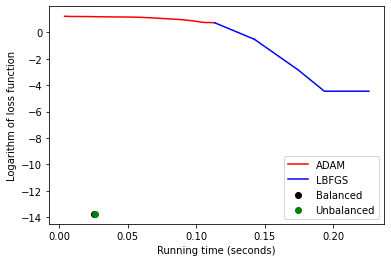

In [19]:
%run scripts/grad_factorization \
    --num_factors 4 \
    --learning_rate 0.1 \
    --results_path results/iterative_vs_hier.npz